# Predict Tweet Toxicity

In [15]:
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack

In [43]:
filename = 'st_shumer_shutdown_focused'
input_filename = "twitter_data/ian_scraped_tweets/"+filename

In [45]:
df = pd.read_csv(input_filename, encoding = "ISO-8859-1",
                 usecols = ['date', 'fullname', 'id', 'likes', 'replies', 
                            'retweets', 'text', 'url', 'user', 'month'])

FileNotFoundError: File b'twitter_data/ian_scraped_tweets/st_shumer_shutdown_focused' does not exist

### Vectorize tweets and predict toxicity with model


In [ ]:
# Load vectorizers
word_vectorizer = pickle.load(open("models/word_vectorizer.pickle", "rb" ))
char_vectorizer = pickle.load(open("models/char_vectorizer.pickle", "rb" ))

In [ ]:
# Vectorize tweets
tweet_word_features = word_vectorizer.transform(df['text'])
tweet_char_features = char_vectorizer.transform(df['text'])
tweet_features = hstack([tweet_word_features, tweet_char_features])

In [ ]:
target_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
# Load models
loaded_models = {}
for col in target_columns:
    loaded_models[col] = pickle.load(open('models/model_{}.sav'.format(col), "rb" ))

In [8]:
# Run models
for col in target_columns:
    df[col] = loaded_models[col].predict_proba(tweet_features)[:, 1]

,date,fullname,id,likes,replies,retweets,text,url,user,month
0,2018-01-20 23:59:59,Matthew Smith,954866126944722944,1,0,0,#ReleaseTheMemo Chuck Schumer should have his ...,/Matthew03136758/status/954866126944722944,Matthew03136758,2018-01-01
1,2018-01-20 23:59:53,strangegarden,954866099916541952,1,0,2,GOP Rep. Labrador: Democrats 'delusional' if t...,/strangegarden7/status/954866099916541952,strangegarden7,2018-01-01
2,2018-01-20 23:59:44,anita larkens Â ð©âð»,954866063342297088,55,5,21,Schumer is right. This is the ONLY chance they...,/anitalarkens/status/954866063342297088,anitalarkens,2018-01-01
3,2018-01-20 23:59:44,Trollhunter,954866062771871744,0,2,0,You said incompetent so it has t be Schumer si...,/Mxyzptlk4Trolls/status/954866062771871744,Mxyzptlk4Trolls,2018-01-01
4,2018-01-20 23:59:41,artfudd,954866048297156608,1,1,0,Inside the Trump-Schumer talks leading up to t...,/artfudd/status/954866048297156608,artfudd,2018-01-01


In [9]:
df['classification'] = df[target_columns].idxmax(axis=1)
df.head()

In [13]:
# export df
export_filename = "classified_data/"+filename
df.to_csv(export_filename)

NameError: name 'word_vectorizer' is not defined

### Visualizations

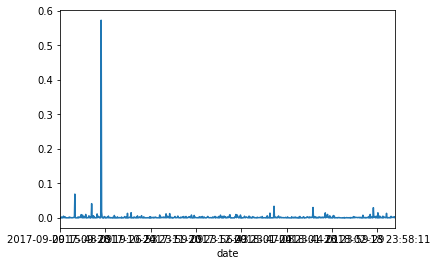

In [107]:
# visualize obscenity
df.groupby('date')['obscene'].mean().plot()

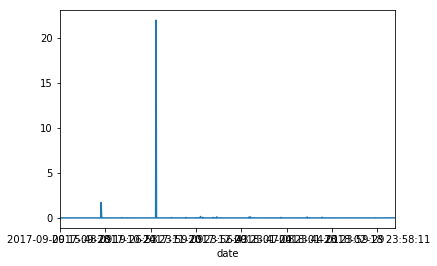

In [108]:
df['likes'] = df['likes'].astype(float)

# normalizing identity hate by tweet popularity
df['popular_obscene'] = df['obscene']*df['likes']
df.groupby('date')['popular_obscene'].mean().plot()

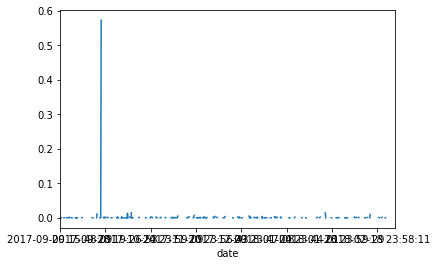

In [109]:
# normalizing identity hate by number of popular tweets
(df.groupby('date')['popular_obscene'].sum() / df.groupby('date')['likes'].sum()).plot()

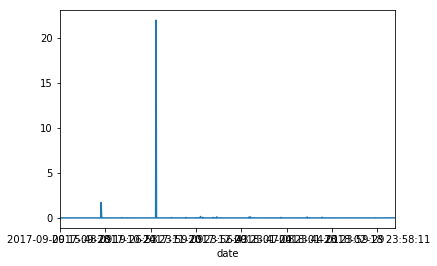

In [110]:
# normalizing popular tweets by number of popular tweets
(df.groupby('date')['popular_obscene'].sum() / df.groupby('date')['likes'].count()).plot()